# ART Adversarial Patch attack

In [80]:
! pip install adversarial-robustness-toolbox

In [81]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install Imagenet stubs to have some image examples
import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs

import random
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label
import warnings
warnings.filterwarnings('ignore')

from art.classifiers.tensorflow import TFClassifier
from art.attacks import AdversarialPatch

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-kk2ohykn
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-kk2ohykn
  Stored in directory: /tmp/pip-ephem-wheel-cache-45b6scoj/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


# Settings

In [0]:
target_image_name = 'toaster.jpg'
patch_shape = (224, 224, 3)
image_shape = (224, 224, 3)
batch_size = 5
scale_min = 0.3
scale_max = 1.0
rotation_max = 22.5
learning_rate = 200000.0
max_iter = 500

# Model definition

In [0]:
_image_input = tf.keras.Input(shape=image_shape)
_target_ys = tf.placeholder(tf.float32, shape=(None, 1000))
model = tf.keras.applications.resnet50.ResNet50(input_tensor=_image_input, weights='imagenet')
_logits = model.outputs[0].op.inputs[0]
target_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_target_ys, logits=_logits))

tfc = TFClassifier(clip_values=(0, 1), input_ph=_image_input, output_ph=_target_ys, logits=_logits,
                   sess=sess, loss=target_loss)

# Imagenet training images

In [0]:
images_list = list()
target_image = None

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    
    if image_path.endswith(target_image_name):
        target_image = im
    else:
        images_list.append(im)

images = random.sample(images_list, batch_size)
images = np.concatenate(images, axis=0)

# Adversarial patch generation

In [0]:
ap = AdversarialPatch(classifier=tfc)

attack_params = {"target": name_to_label('toaster'), "rotation_max": rotation_max, "scale_min": scale_min,
                 "scale_max": scale_max, "learning_rate": learning_rate, "max_iter": max_iter,
                 "patch_shape": patch_shape, "batch_size": batch_size,
                 "clip_patch": [(-103.939, 255.0 - 103.939), (-116.779, 255.0 - 116.779), (-123.680, 255.0 - 123.680)]}

patch, patch_mask = ap.generate(x=images, **attack_params)

In [0]:
def from_keras(x):
    x = np.copy(x)
    x[:, :, 2] += 123.68
    x[:, :, 1] += 116.779
    x[:, :, 0] += 103.939
    return x[:, :, [2, 1, 0]].astype(np.uint8)

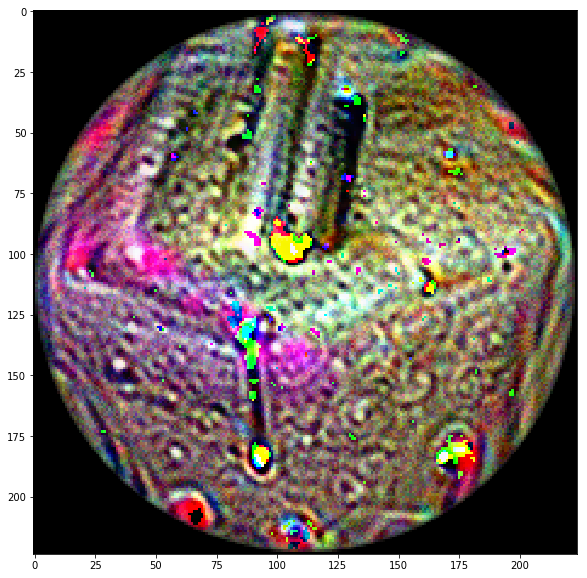

In [87]:
plt.imshow((from_keras(patch) * patch_mask).astype(np.uint))

# Evaluation

In [0]:
def predict_model(model, image):
    plt.figure(figsize=(3,3))
    plt.imshow((from_keras(image)).astype(np.uint))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    prediction = model.predict(image)
    
    top = 3
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

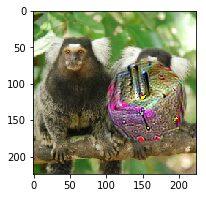

Predictions:
marmoset 0.54
toaster  0.11
padlock  0.08


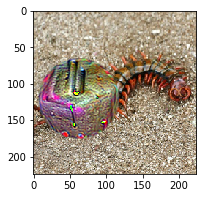

Predictions:
toaster       1.00
switch        0.00
parking_meter 0.00


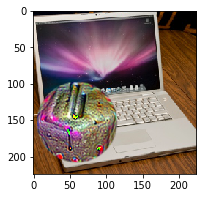

Predictions:
toaster  0.87
notebook 0.08
mouse    0.03


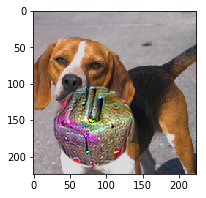

Predictions:
toaster          0.89
dumbbell         0.05
pencil_sharpener 0.01


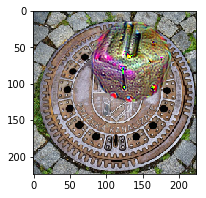

Predictions:
manhole_cover 0.91
switch        0.03
toaster       0.02


In [99]:
images = random.sample(images_list, batch_size)
images = np.concatenate(images, axis=0)
patched_images = ap.apply_patch(images, scale=0.5)
for i in range(len(patched_images)):
  predict_model(model, patched_images[i, :, :, :])

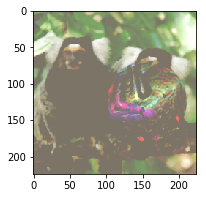

Predictions:
padlock     0.05
leaf_beetle 0.05
chiton      0.05


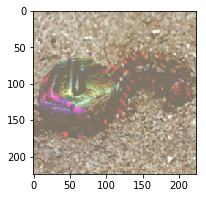

Predictions:
screw   0.24
switch  0.19
padlock 0.07


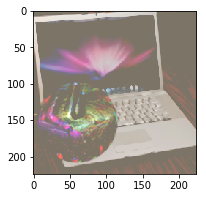

Predictions:
notebook         0.21
desktop_computer 0.15
projector        0.12


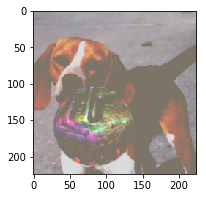

Predictions:
EntleBucher                0.16
Greater_Swiss_Mountain_dog 0.13
boxer                      0.09


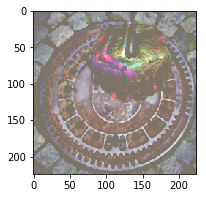

Predictions:
combination_lock 0.41
manhole_cover    0.10
sundial          0.07


In [100]:
from art.defences import SpatialSmoothing

img_adv = patched_images

fs = SpatialSmoothing()
img_def = fs(img_adv, clip_values=(0, 255))
# img_adv.shape
# img_def[0].shape
img_def = img_def[0]
for i in range(len(img_def)):
  predict_model(model, img_def[i, :, :, :])

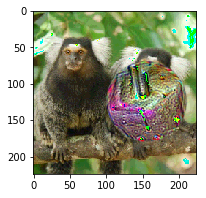

Predictions:
marmoset 0.48
toaster  0.19
titi     0.07


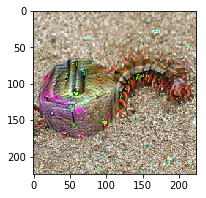

Predictions:
toaster       1.00
switch        0.00
parking_meter 0.00


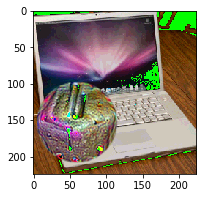

Predictions:
toaster  0.91
notebook 0.04
mouse    0.03


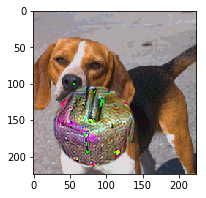

Predictions:
toaster          0.82
dumbbell         0.09
pencil_sharpener 0.01


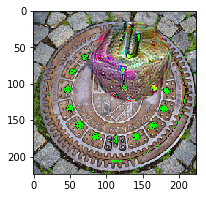

Predictions:
manhole_cover 0.91
switch        0.03
toaster       0.01


In [101]:
from art.defences import FeatureSqueezing

img_adv = patched_images

fs = FeatureSqueezing(bit_depth=4)
img_def = fs(img_adv, clip_values=(0, 255))
# img_adv.shape
# img_def[0].shape
img_def = img_def[0]
for i in range(len(img_def)):
  predict_model(model, img_def[i, :, :, :])

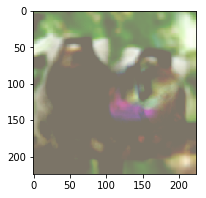

Predictions:
bubble 0.20
abaya  0.05
cloak  0.02


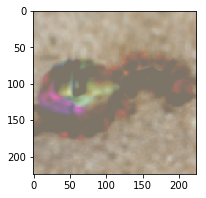

Predictions:
scorpion 0.10
bubble   0.05
hook     0.03


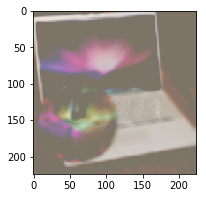

Predictions:
projector        0.09
desktop_computer 0.07
printer          0.06


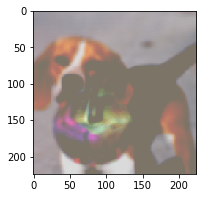

Predictions:
soccer_ball 0.11
Boston_bull 0.07
knee_pad    0.06


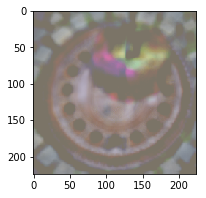

Predictions:
birdhouse  0.20
spindle    0.08
oil_filter 0.07


In [102]:
from art.defences import TotalVarMin

img_adv = patched_images

fs = TotalVarMin(clip_values=(0, 255))
img_def = fs(img_adv)
# img_adv.shape
# img_def[0].shape
img_def = img_def[0]
for i in range(len(img_def)):
  predict_model(model, img_def[i, :, :, :])

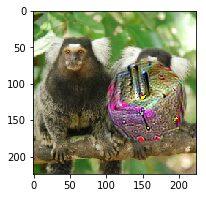

Predictions:
marmoset 0.54
toaster  0.11
padlock  0.08


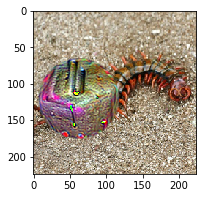

Predictions:
toaster       1.00
switch        0.00
parking_meter 0.00


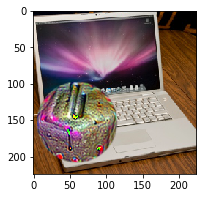

Predictions:
toaster  0.87
notebook 0.08
mouse    0.03


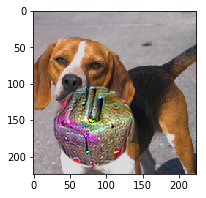

Predictions:
toaster          0.89
dumbbell         0.05
pencil_sharpener 0.01


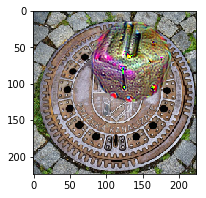

Predictions:
manhole_cover 0.91
switch        0.03
toaster       0.02


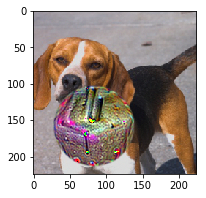

Predictions:
toaster          0.90
dumbbell         0.04
pencil_sharpener 0.01


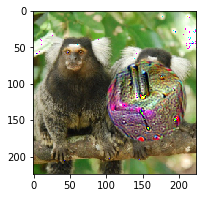

Predictions:
marmoset 0.51
toaster  0.11
padlock  0.09


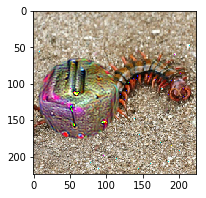

Predictions:
toaster 1.00
switch  0.00
padlock 0.00


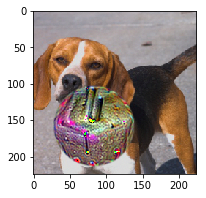

Predictions:
toaster          0.87
dumbbell         0.06
pencil_sharpener 0.01


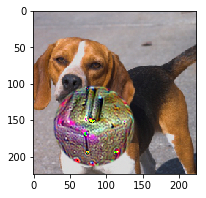

Predictions:
toaster          0.88
dumbbell         0.05
pencil_sharpener 0.01


In [103]:
from art.defences import GaussianAugmentation

img_adv = patched_images

fs = GaussianAugmentation()
img_def = fs(img_adv)
# img_adv.shape
# img_def[0].shape
img_def = img_def[0]
for i in range(len(img_def)):
  predict_model(model, img_def[i, :, :, :])